# 2025-04-21 Galerkin methods

## Last time

* PETSc experiments / project work
* multigrid

## Today

* Galerkin methods
  * Weak forms
  * $L^2$ Projection
  * Galerkin "optimality"

In [2]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


my_spy (generic function with 1 method)

# Integration by parts

## One dimension

* it's the product rule backwards

\begin{align} \int_a^b \mathrm{d}(uv) &= \int_a^b u \mathrm{d}v + \int_a^b v \mathrm{d}u \\
(uv)_a^b &= \int_a^b u \mathrm{d}v + \int_a^b v \mathrm{d}u \\
\int_a^b u \mathrm{d}v &= (uv)_a^b - \int_a^b v \mathrm{d}u
\end{align}


## Multiple dimensions

* abuse of notation: omit the $\mathrm{d}A, \mathrm{d}V$ corresponding to appropriate area/volume/etc. element for integration over the domain $\partial \Omega, \Omega$

\begin{align}
\int_\Omega v \nabla\cdot \mathbf f = -\int_\Omega \nabla v \cdot \mathbf f + \int_{\partial \Omega} v \mathbf f \cdot \mathbf n
\end{align}

## Strong form

$$ -\nabla\cdot(\kappa \nabla u) = 0 $$

## Weak form
* multiply by a test function and integrate by parts

\begin{align} -\int_\Omega v \nabla\cdot(\kappa \nabla u) = 0, \quad \forall v \\
\int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0
\end{align}

# Variational: from minimization to weak forms

## Minimization

Find $u\in \mathcal V$ such that

\begin{align}
u &= \arg\min \int_\Omega \frac 1 p \lVert \nabla u \rVert^p \\
&= \arg\min \int_\Omega \frac 1 p (\nabla u \cdot \nabla u)^{p/2}
\end{align}

## Variations

> If $f(x)$ is a minimum, then $df = f'(x) dx = 0$ for all $dx$.

So if $u \in \mathcal V$ is a minimizer, then 
\begin{align}
\int_\Omega \underbrace{\lVert \nabla u \rVert^{p-2}}_{\kappa(u)} \nabla u \cdot \nabla du = 0
\end{align}
for all $du \in \mathcal V$.

* It's common to use $v$ in place of $du$.
* Our discretization will reflect this structure

$$ v_h^T F(u_h) \sim \int_\Omega \nabla v \cdot \kappa(u) \cdot \nabla u $$

# Finite elements

## Problem statement

Find $u \in \mathcal V$ such that
\begin{align} \int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0, \forall v \in \mathcal V
\end{align}

### What do we need?
* A way to integrate
* A space $\mathcal V$
* Boundary conditions

## Ciarlet (1978) definition

A **finite element** is a triple $(K, P, N)$ where
* $K$ is a bounded domain with piecewise smooth boundary
* $P = \{p_j\}_1^k$ is a finite-dimensional function space over $K$ ("prime basis")
* $N = \{n_i\}_1^k$ is a basis for the dual space ("nodes")

It is common for nodes to be pointwise evaluation
$$ \langle n_i, p_j \rangle = p_j(x_i) $$

### First: choose a single element $K = \Omega$

# Quadrature

Our elements will be a line segment and we'll define quadrature on the standard line segment, $\hat K = (-1, 1)$. A quadrature is a set of points $q_i$ and weights $w_i$ such that
$$ \int_{-1}^1 f(x) \approx \sum_{i=1}^n w_i f(q_i) $$

In [3]:
default(linewidth=4)
function quad_trapezoid(n)
    q = LinRange(-1, 1, n)
    w = 2 * ones(n) / (n - 1)
    w[[1,end]] ./= 2
    q, w
end

function plot_quad_accuracy(f, F, quad)
    ns = 2 .^ (2:7)
    exact = F(1) - F(-1)
    function err(n)
        q, w = quad(n)
        w' * f.(q) - exact
    end
    errors = [abs.(err(n)) for n in ns]
    plot(ns, errors, marker=:auto, label=quad)
    plot!(ns, ns.^(-2), xscale=:log10, yscale=:log10)    
end

plot_quad_accuracy (generic function with 1 method)

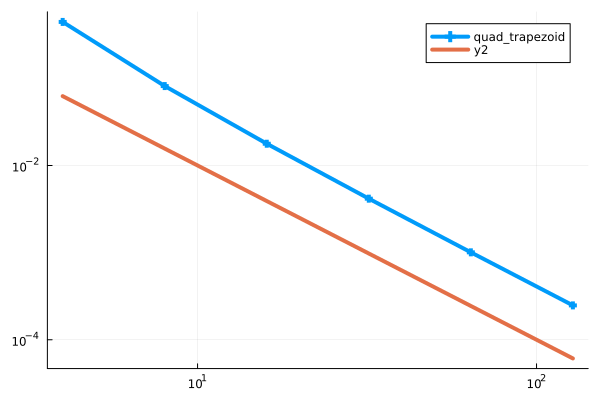

In [4]:
#plot_quad_accuracy(exp, exp, quad_trapezoid)
plot_quad_accuracy(x -> 3*x^2, x -> x^3, quad_trapezoid)

# Integration via polynomial interpolation

* Pick some points $x_i$
* Evaluate the function there $f_i = f(x_i)$
* Find the polynomial that interpolates the data
* Integrate the polynomial

## What order of accuracy can we expect?
* What degree polynomials can be integrate exactly?

# Doing better: Gauss quadrature

Suppose a polynomial on the interval $[-1,1]$ can be written as

$$ P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Why is $\int_{-1}^1 P_n(x) q(x) = 0$?
* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

# Gauss-Legendre in code

1. Solve for the points, compute the weights
  * Use a Newton solver to find the roots. You can use the recurrence to write a recurrence for the derivatives.
  * Create a Vandermonde matrix and extract the first row of the inverse or (using more structure) the derivatives at the quadrature points.
2. Use duality of polynomial roots and matrix eigenvalues.
  * A fascinating mathematical voyage (topic of graduate linear algebra class).

In [6]:
function gauss_legendre(n)
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = @. .5 / sqrt(1 - (2 * (1:n-1))^(-2))
    T = diagm(-1 => beta, 1 => beta)
    D, V = eigen(T)
    w = V[1,:].^2 * 2
    q = D
    q, w
end

gauss_legendre (generic function with 1 method)

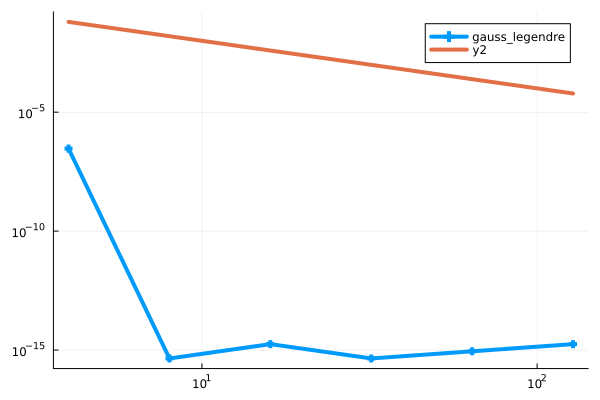

In [7]:
plot_quad_accuracy(exp, exp, gauss_legendre)
#plot_quad_accuracy(x -> 0.5*x^2, x -> x, gauss_legendre)


# Legendre polynomials

In [8]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

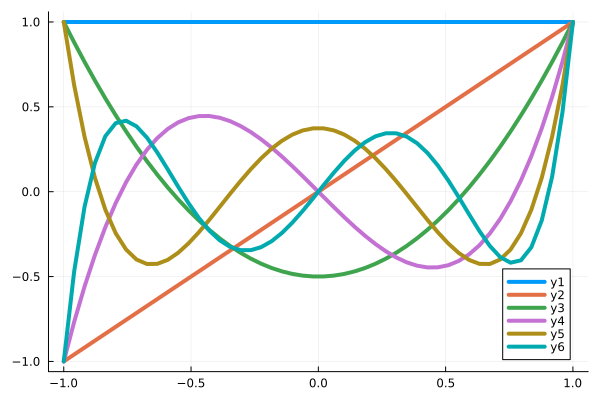

In [21]:
x = LinRange(-1, 1, 50)
P = vander_legendre(x, 6)
plot(x, P)

# Prime to nodal basis

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = \langle n_i, p_j \rangle$,
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

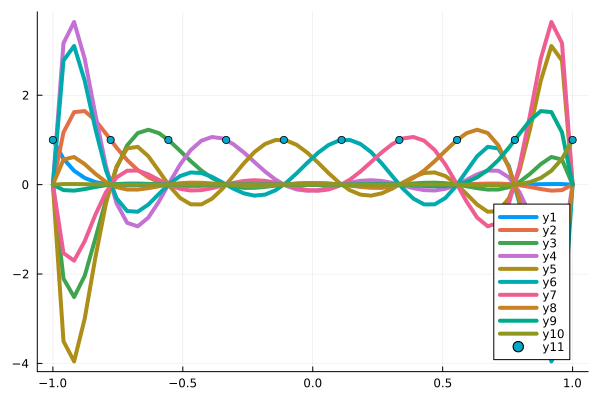

In [22]:
k = 10
xn = LinRange(-1, 1, k)
V = vander_legendre(xn)
xx = LinRange(-1, 1, 50)
Pxx = vander_legendre(xx, k)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

[ Info: Precompiling FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838] (cache misses: wrong dep version loaded (2))


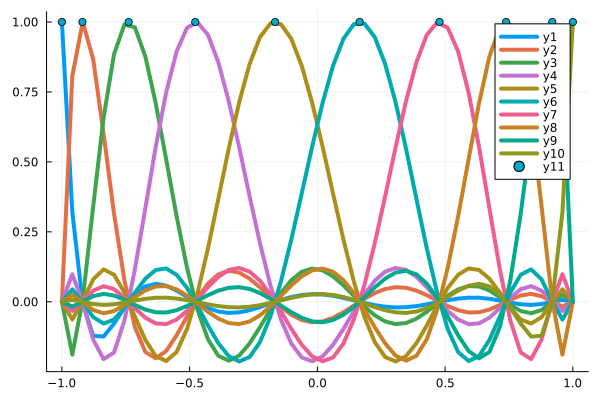

In [23]:
using FastGaussQuadrature
xn, _ = gausslobatto(k)
V = vander_legendre(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))